In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, pearsonr
import os

# Use pretrained model

In [ ]:
model_path = "cellformer_pbmc/"
peak_matrix = "pbmc_data/aggregated_sc_mixture.csv"
groundtruth = "pbmc_data/agg_sc_separate.npz"
!python src/2_deconvolution/inference.py --model_path {model_path} --model SepFormerTasNet --peak_count_matrix {peak_matrix} --groundtruth {groundtruth} --type pseudobulk --mask

# Plot model performances

In [9]:
df_metrics_sep = pd.read_csv(model_path + "aggregated_sc_mixturemask_metrics_cv.csv")
df_metrics_sep["method"] = "Cellformer"

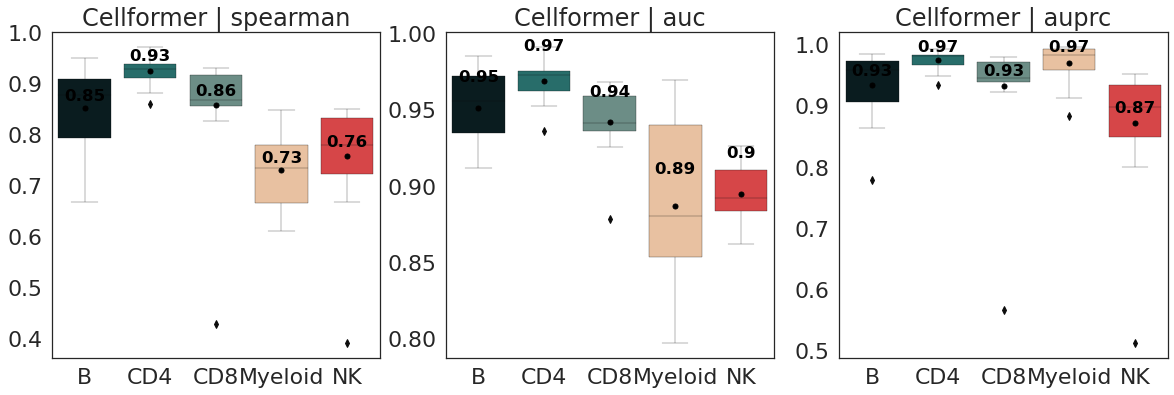

In [15]:
####PER CELL TYPE
celltypes = ["B", "CD4", "CD8", "Myeloid", "NK"]
palette_cell = {"B":"#071E22",
                "CD4":"#1D7874","CD8":"#679289",
                "Myeloid":"#F4C095",
                "NK":"#EE2E31"}

fig, axes = plt.subplots(1,3, figsize=(20,6))
axes = axes.flatten()
sns.set(font_scale=2, style="white")
fontsize=18
tmp_method = "Cellformer"
df_tmp = df_metrics_sep[df_metrics_sep.method ==tmp_method]
for indx, it in enumerate(["spearman", "auc", "auprc"]):
    tmp = df_tmp[df_tmp.metrics==it]
    ax = axes[indx]
    sns.boxplot(data=tmp,x="celltype",
                hue="celltype",
                y="res", palette=palette_cell,
                ax=ax,
                showmeans=True,
                dodge=False,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.3)#, notch=True)
    means = tmp.groupby(['celltype'])['res'].mean().round(2)
    vertical_offset = tmp['res'].mean() * 0.02
    for xtick in ax.get_xticks():
            ax.text(xtick,
                    means[xtick] + vertical_offset,
                    means[xtick], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
    ax.set_xlabel("")
    ax.set_title(tmp_method + " | " + it)
    ax.set_ylabel("")
    ax.get_legend().remove()
plt.savefig(os.path.join(model_path, "box_comp_CV_CELLTYPE.svg"),
                bbox_inches="tight")
plt.show()

# Plot predicted versus true values

In [40]:
pred = np.load(model_path + "aggregated_sc_mixturepred_.npy")
gt = np.load(model_path + "aggregated_sc_mixturegt_.npy")

In [41]:
mean_pred = pred.mean(0)
mean_gt = gt.mean(0)
mean_gt.shape

(5, 42854)

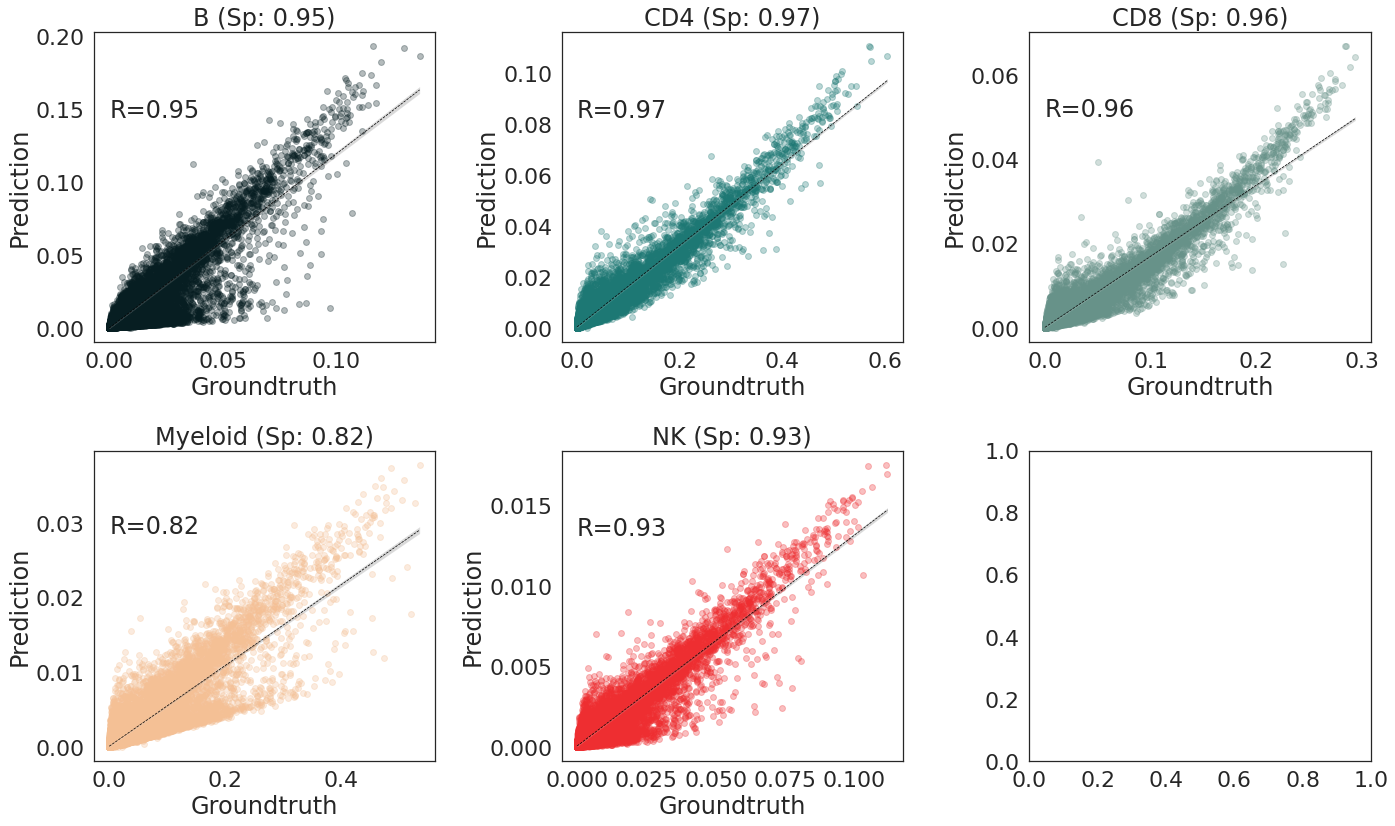

In [47]:
fontsize=fontsize
sns.set(font_scale=2, style="white")

fig, axes = plt.subplots(2,3, figsize=(20,12))
axes = axes.flatten()
for i,ct in enumerate(celltypes):

    sns.regplot(x=mean_gt[i], y=mean_pred[i], ax=axes[i], color="black",
                line_kws={"linewidth":0.7, "linestyle":"--"}, #palette_cell[ct],
               scatter_kws={"s":35, "color":palette_cell[ct],"alpha":0.3 })
    r, p = spearmanr(mean_gt[i], mean_pred[i])
    axes[i].text(mean_gt[i].min(), np.quantile(mean_pred[i],0.999), 'R={:.2f}'.format(r, p))
    axes[i].set_xlabel("Groundtruth")
    axes[i].set_ylabel("Prediction")
    axes[i].set_title(ct + " (Sp: %s"%str(np.round(r,2))+")")

fig.tight_layout()

plt.savefig(model_path + "regplot_pred_true.png")
plt.show()

plt.close("all")
